NOAA dataset normalized. Eight  features. Two classes.
50 batches of 345 instances



METHOD: Static lp as classifier
Execution time:  0.44388126259033867
Average MCC:  0.12331645012680108
Average error: 30.116200000000006
Average macro-F1: 0.4639590966758134
Average micro-F1: 0.6759999999999999
Acurácia Média:  69.8838
Desvio Padrão:  4.4165714711753505
Variância:  19.50610356


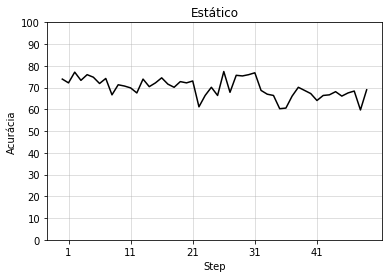

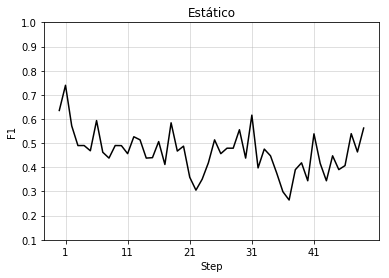




METHOD: Sliding lp as classifier
Execution time:  0.32454545709013527
Average MCC:  0.007492686492653552
Average error: 31.280399999999986
Average macro-F1: 0.3967599443369747
Average micro-F1: 0.6583999999999999
Acurácia Média:  68.71960000000001
Desvio Padrão:  4.624649591050116
Variância:  21.387383840000005


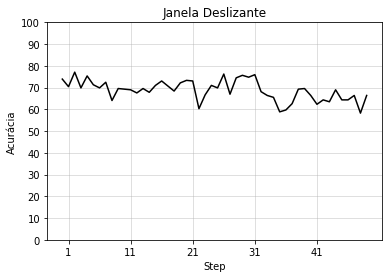

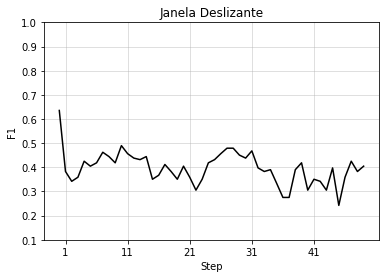




METHOD: Incremental lp as classifier
Execution time:  16.793317996070616
Average MCC:  0.040422348558248285
Average error: 30.857799999999983
Average macro-F1: 0.42571575501254416
Average micro-F1: 0.6656
Acurácia Média:  69.14220000000002
Desvio Padrão:  4.787241080204756
Variância:  22.917677159999997


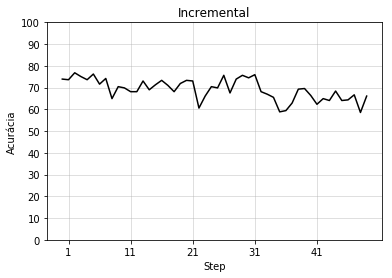

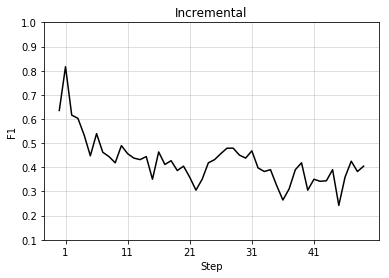




METHOD: lp as classifier and kde as core support extraction with cutting data method
Execution time:  0.8894277077800474
Average MCC:  0.007492686492653552
Average error: 31.286199999999994
Average macro-F1: 0.3967599443369747
Average micro-F1: 0.6583999999999999
Acurácia Média:  68.7138
Desvio Padrão:  4.6226822906187275
Variância:  21.369191560000004


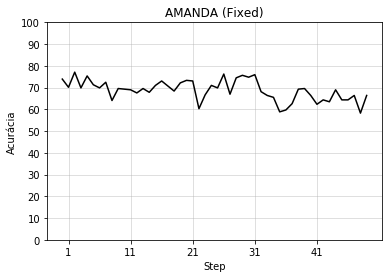

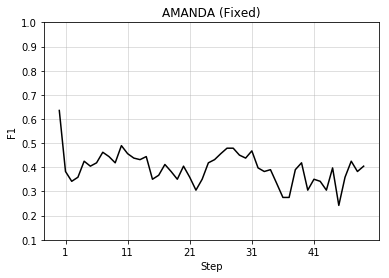




METHOD: lp as classifier and kde and Hellinger distance as dynamic CSE
AMANDA-DCP Hellinger | Mean keeping percentage=0.10 | Std keeping percentage=0.01
Execution time:  0.8539170823662019
Average MCC:  0.01324059401012863
Average error: 60.4236
Average macro-F1: 0.3133238483161059
Average micro-F1: 0.4512
Acurácia Média:  39.5764
Desvio Padrão:  13.535481042061269
Variância:  183.20924704


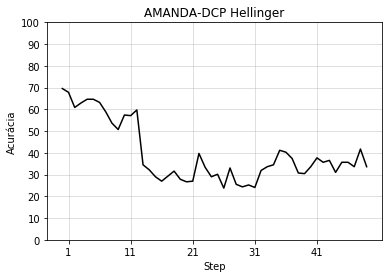

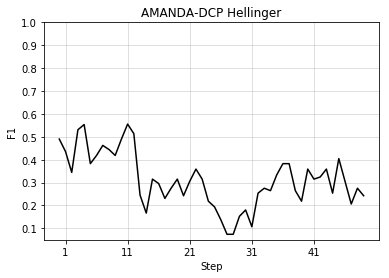




METHOD: lp as classifier and kde and Hellinger2 distance as dynamic CSE
AMANDA-DCP Hellinger2 | Mean keeping percentage=0.19 | Std keeping percentage=0.03
Execution time:  0.9254424910186181
Average MCC:  0.031230315827013813
Average error: 43.72820000000001
Average macro-F1: 0.4340136774360943
Average micro-F1: 0.5676
Acurácia Média:  56.27179999999999
Desvio Padrão:  6.950731958578175
Variância:  48.31267475999999


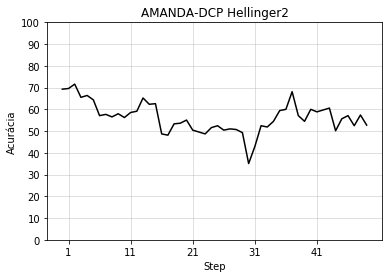

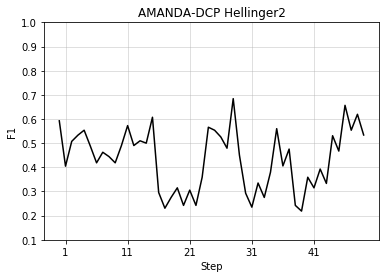




METHOD: lp as classifier and kde and BBD distance as dynamic CSE
AMANDA-DCP BBD - β = -1.000 | Mean keeping percentage=0.19 | Std keeping percentage=0.06
Execution time:  0.8681184089761871
Average MCC:  -0.07892644394037006
Average error: 57.99379999999999
Average macro-F1: 0.3328732106385914
Average micro-F1: 0.414
Acurácia Média:  42.00620000000001
Desvio Padrão:  5.747968646400222
Variância:  33.03914356000001


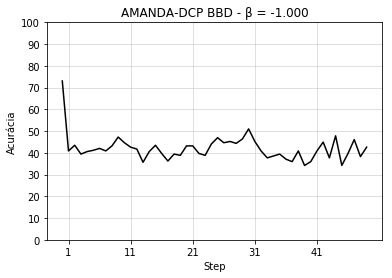

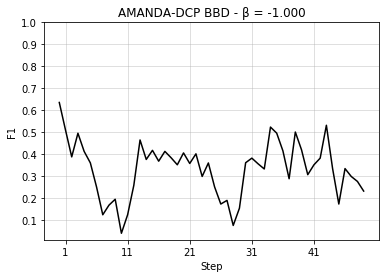

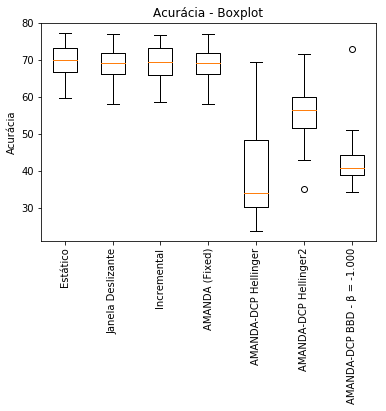

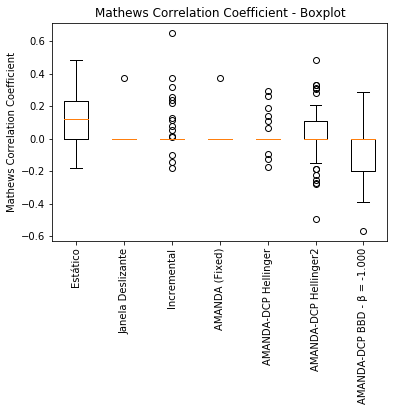

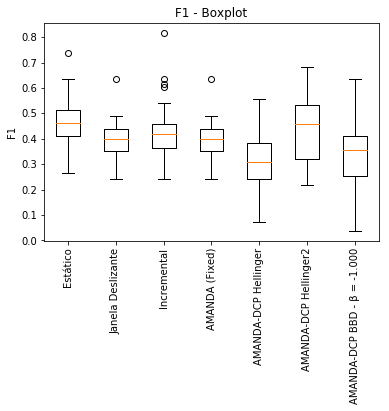

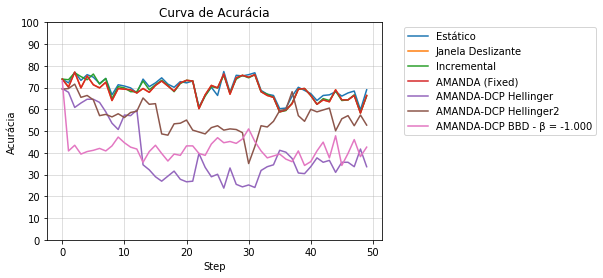

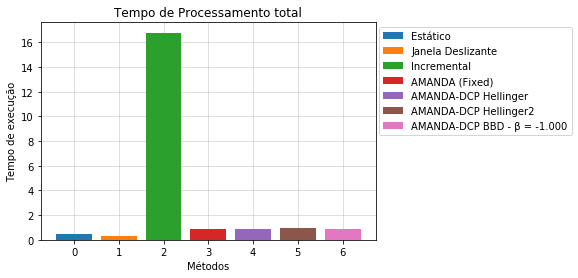

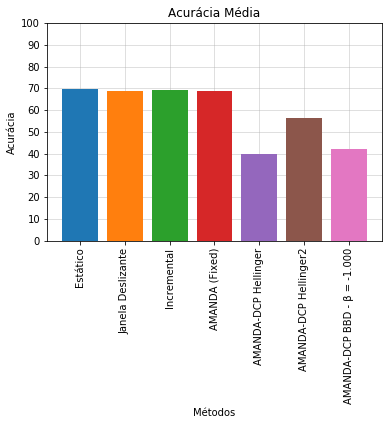

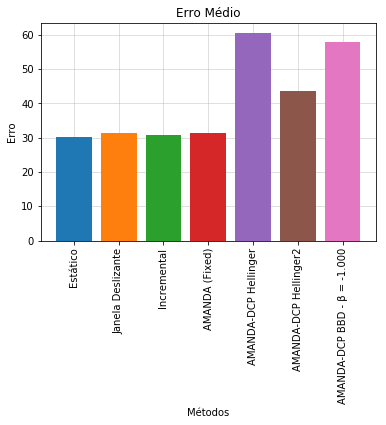

Pos 3 - Redução do Erro (Janela Deslizante):-1.6659082648624999
Pos 2 - Redução do Erro (Incremental):-1.0611901470726792
Pos 4 - Redução do Erro (AMANDA (Fixed)):-1.6742077563040185
Pos 7 - Redução do Erro (AMANDA-DCP Hellinger):-43.36827705419567
Pos 5 - Redução do Erro (AMANDA-DCP Hellinger2):-19.478047845137215
Pos 6 - Redução do Erro (AMANDA-DCP BBD - β = -1.000):-39.891362518924254


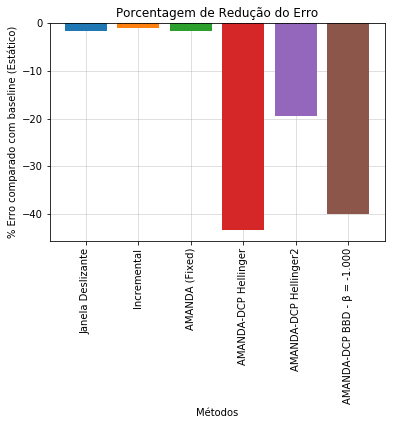

In [1]:
%matplotlib inline
import sys
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).resolve().parents[4])
import psutil
import setup
from methods import runExperiments
from methods import static_classifier
from methods import amanda_dynamic
from methods import amanda_fixed
from methods import incremental_LN
from methods import deslizante_LN
from methods import compose_gmm_version
'''
from methods import prequential_amanda_fixed
from methods import prequential_amanda_dynamic
from methods import prequential_static_classifier
from methods import prequential_deslizante_LN
from methods import prequential_incremental_LN
from methods import prequential_compose_gmm_version
'''


class Experiment():
     def __init__(self, method, K=None, excludingPercentage=None, densityFunction=None, clfName=None, distanceMetric=None, beta=None):
        self.method = method
        self.clfName = clfName
        self.densityFunction=densityFunction
        self.excludingPercentage = excludingPercentage
        self.K_variation = K
        self.distanceMetric = distanceMetric
        self.beta = beta


def loadLevelResults(path, sep, key, steps):
    originalAccs, F1s, time = setup.loadLevelIwBoxplotResults(path, sep)
    predictions = F1s[key]
    predictions = [ predictions[i::steps] for i in range(steps) ]
    
    return predictions, originalAccs[key], time[key]


def main():
    experiments = {}
    is_windows = sys.platform.startswith('win')
    sep = '\\'

    if is_windows == False:
        sep = '/'

    path = os.getcwd()+sep+'data'+sep
    
    # SETTINGS
    sslClassifier = 'lp' # lp = label propagation, rf = random forests, cl = cluster and label, knn = k-nn, svm = svm
    steps = 50
    poolSize = None
    isBatchMode = True # False = Stream
    isBinaryClassification = True
    isImbalanced = True
    externalResults = []
    plot_animation = False
    
    # Load dataset
    dataValues, dataLabels, description = setup.loadNOAA2Dataset(path, sep)
    
    # 5% of initial labeled data
    labeledData = int(0.05*len(dataLabels))
    
    # Static SSL
    experiments[0] = Experiment(static_classifier, 4, clfName=sslClassifier)
    
    # Sliding SSL
    experiments[1] = Experiment(deslizante_LN, 4, clfName=sslClassifier)
    
    # Incremental SSL
    experiments[2] = Experiment(incremental_LN, 4, clfName=sslClassifier)
        
    # Proposed Method 1 (AMANDA - Fixed core extraction percentage)
    experiments[3] = Experiment(amanda_fixed, 4, 0.6, "kde", sslClassifier)
    
     # Proposed method 2 (AMANDA - DCP Original)
    experiments[4] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'Hellinger')
    
    # Proposed method 3 (AMANDA - DCP Hellinger2)
    experiments[5] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier, 'Hellinger2')                         
    
    # Proposed method 4 (AMANDA - DCP BBD)
    lastIndex = list(experiments.keys())[-1]
    #betas = [-1, 2, 3, 10]
    #bestK = [5, 5, 5, 5]
    betas = [-1]
    bestK = [3]
    for i in range(len(betas)):
        experiments[lastIndex+1+i] = Experiment(amanda_dynamic, bestK[i], None, "kde", sslClassifier, 'BBD', beta=betas[i])
    
     # Proposed method 5 (AMANDA - DCP HDDDM)
    #experiments[17] = Experiment(amanda_dynamic, 5, None, "kde", sslClassifier, 'HDDDM')
    
    '''
    # memory usage
    #process = psutil.Process(os.getpid())
    
    # Proposed method 2 (AMANDA - Dynamic core extraction percentage)
    #experiments[4] = Experiment(amanda_dynamic, 6, None, "kde", sslClassifier)
    
    #print("Memory:", process.memory_info().rss)

    # COMPOSE GMM (Python version)
    #experiments[5] = Experiment(compose_gmm_version, 8)
    
    
    #prequential evaluation
    steps = 10
    dataValues, dataLabels = dataValues[:labeledData], dataLabels[:labeledData]
    labeledData = int(0.05*len(dataLabels))
    experiments[0] = Experiment(prequential_static_classifier, 8, clfName=sslClassifier)
    experiments[1] = Experiment(prequential_deslizante_LN, 8, clfName=sslClassifier)
    experiments[2] = Experiment(prequential_incremental_LN, 8, clfName=sslClassifier)
    experiments[3] = Experiment(prequential_amanda_fixed, 8, 0.7, "kde", sslClassifier)
    experiments[4] = Experiment(prequential_amanda_dynamic, 6, None, "kde", clfName=sslClassifier)
    experiments[5] = Experiment(prequential_compose_gmm_version, 8, 0.7)
    
    # levelIw matlab results
    predictionsLevelIw, originalAccsLevelIw, timeLevelIw = loadLevelResults(path, sep, 'noaa', steps)
    externalResults.append({"name":"Level IW", "predictions":predictionsLevelIw, "accuracies":originalAccsLevelIw, "time":timeLevelIw})
    '''
    # Run experiments
    runExperiments.run(dataValues, dataLabels, description, isBinaryClassification, isImbalanced, 
                       experiments, steps, labeledData, isBatchMode, poolSize, externalResults)
    
    
    

if __name__ == "__main__":
    main()